In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()

# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *

# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D

# import external libs
import cv2
import pandas as pd

EXPERIMENT = 'temp/PhaseRegression-tests'

# ------------------------------------------generator hyperparameters
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 1 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
DIM = [60, 192, 192] # network input params for spacing of 3, (z,y,x)
T_SHAPE = 35
SPACING = [2, 2, 2] # if resample, resample to this spacing, (z,y,x)
# maybe we can drop this channel?
#IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
#MASKING_IMAGE = False # make curently no sense for regression
#MASKING_VALUES = [2] 
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered_old/SAx_3D_dicomTags_phase'
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 5
SMOOTHING_LOWER_BORDER = 0.2
SMOOTHING_UPPER_BORDER = 0.4
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 1
SHUFFLE = True
RESAMPLE = True
SCALER = 'Standard' # MinMax Standard or Robust

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


2021-02-10 18:27:50,659 INFO -------------------- Start --------------------
2021-02-10 18:27:50,659 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-02-10 18:27:50,660 INFO Log file: ./logs/temp/PhaseRegression-tests.log
2021-02-10 18:27:50,660 INFO Log level for console: INFO


{'SEED': 42, 'EXPERIMENT': 'temp/PhaseRegression-tests', 'BATCHSIZE': 1, 'GENERATOR_WORKER': 1, 'DIM': [60, 192, 192], 'T_SHAPE': 35, 'SPACING': [2, 2, 2], 'MASK_VALUES': [1, 2, 3], 'MASK_CLASSES': 3, 'DF_META': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered_old/SAx_3D_dicomTags_phase', 'TARGET_SMOOTHING': True, 'SMOOTHING_KERNEL_SIZE': 5, 'SMOOTHING_LOWER_BORDER': 0.2, 'SMOOTHING_UPPER_BORDER': 0.4, 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': True, 'AUGMENT_PROB': 1, 'SHUFFLE': True, 'RESAMPLE': True, 'SCALER': 'Standard', 'CONFIG_PATH': 'reports/config/temp/PhaseRegression-tests', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/temp/PhaseRegression-tests', 'MODEL_PATH': 'models/temp/PhaseRegression-tests', 'HISTORY_PATH': 'reports/history/temp/PhaseRegression-tests'}


In [2]:
# zip the phase files in the following structure:
#[[patient1_phase1, patient1_phase2, patient1_phase3, patient1_phase4, patient1_phase5],[patient2_phase1...] ...]

images = sorted(glob.glob('/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/*clean.nrrd'))
print(len(images))

279


In [3]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
config['AUGMENT'] = False
config['RESAMPLE'] = True
batch_generator = PhaseRegressionGenerator(images, images, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
validation_generator = PhaseRegressionGenerator(images, images , config=val_config)

2021-02-10 18:27:52,099 INFO Create DataGenerator
2021-02-10 18:27:52,100 INFO Datagenerator created with: 
 shape: [60, 192, 192]
 spacing: [2, 2, 2]
 batchsize: 1
 Scaler: Standard
 Images: 279 
 Augment: False 
 Thread workers: 1
2021-02-10 18:27:52,100 INFO No augmentation
2021-02-10 18:27:52,115 INFO [0.2 0.4 1.  0.4 0.2]
2021-02-10 18:27:52,116 INFO Create DataGenerator
2021-02-10 18:27:52,118 INFO Datagenerator created with: 
 shape: [60, 192, 192]
 spacing: [2, 2, 2]
 batchsize: 1
 Scaler: Standard
 Images: 279 
 Augment: False 
 Thread workers: 1
2021-02-10 18:27:52,118 INFO No augmentation
2021-02-10 18:27:52,132 INFO [0.2 0.4 1.  0.4 0.2]


In [4]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(batch_generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    import time
    global inputs, outputs
    t1 = time.time()
    inputs, outputs = batch_generator.__getitem__(batch)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    
    selected_input = inputs[im]
    selected_output = outputs[im]
    
    logging.info(selected_output)
    
    list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
    plt.show()
    info('-'*100)
    #list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_output))
    
    """
        show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
    plt.show()
    """
    plt.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=139, description='batch', max=279), IntSlider(value=0, description='im',…

In [8]:
outputs.shape

(1, 5, 35)

In [78]:
temp = outputs[0][:]
print(temp.shape)
print(temp[0])

(5, 35)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [91]:
# smooth the one-hot vectors along the indexes
# each phase has a small range of valid indexes with a convolved smoothing
import sys
temp = np.copy(outputs[0])
kernelsize = 5
lower = 0.1
upper = 0.5
# create a kernel with linearly increasing, than one, than decreasing smoothing
kernel = np.concatenate([np.linspace(lower,upper,kernelsize//2), [1], np.linspace(upper,lower,kernelsize//2)])
print('Kernel: {}'.format(kernel))
for idx in range(temp.shape[0]):
    print(temp[idx])
    smoothed = np.convolve(temp[idx],kernel, mode='same')
    print('convolved: {}'.format(smoothed))
    smoothed = smoothed/(sum(smoothed) + sys.float_info.epsilon)
    print('normalised: {}'.format(smoothed))
    temp[idx] = smoothed


Kernel: [0.1 0.5 1.  0.5 0.1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
convolved: [0.  0.  0.  0.  0.  0.  0.  0.1 0.5 1.  0.5 0.1 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
normalised: [0.         0.         0.         0.         0.         0.
 0.         0.04545455 0.22727273 0.45454545 0.22727273 0.04545455
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
convolved: [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.5 1.  0.5 0.1 0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
normalised: [0.         0.         0.         0.         0.         0.
 0.  

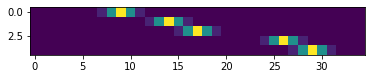

In [92]:
plt.imshow(temp)

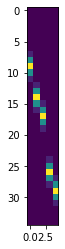

In [93]:
plt.imshow(temp.T)

In [118]:
# load phase indicies from the df
print(len(images))
patient_temp = images[0]
# search for the 8 digits of the patient ID which should have a underscore in before and than a minus
patient_str = re.search('-(.{8})_', patient_temp).group(1)
df = pd.read_csv('/mnt/ssd/data/gcn/02_imported_4D_unfiltered_old/SAx_3D_dicomTags_phase')
df = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
df[df.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']].values[0].astype(int) -1

279


array([13,  2,  5,  7, 11])

In [116]:
import re
a = get_patient(patient_temp)

re.search('-(.{8})_', patient_temp).group(1)

'02Z1L14N'

In [15]:
%%timeit
temp.mean()

2.65 ms ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
np.mean(temp)

2.69 ms ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
np.linspace(-1,1,10)

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])